## [RQ1] 
Who wants to be a Champion? During a season could happen that a team has bad periods. For example, more than three consecutive games lost, or it could have a positive trend where it seems to be unbeatable. Let's visualize this trends!

Create a plot where each point (x,y) represents the number of points obtained by team x at game week y. In order to show the trends, points related to the same team must be connected to each other. Remind: in soccer each team gets 3 points for a win, 1 point for a tied game, and 0 for a loss. Highlight the two teams that got the longest winning streak (# of consecutive wins), and the two teams that got the longest losing streak (# of consecutive losses).

Below you can see a similar example of what we would like you to show us. Keep in mind that you must create this plot for all the entire season (38 game weeks).

In [87]:
import pandas as pd 
import numpy as np 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
import json
from pandas.io.json import json_normalize 
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
coaches=pd.read_json("coaches.json")
coaches.head()
coaches.shape

(208, 9)

In [89]:
teams=pd.read_json("teams.json")
teams.head()
teams.shape

(142, 6)

In [90]:
matches_england=pd.read_json(r"./matches/matches_England.json")
matches_england.head()
matches_england.shape

(380, 14)

In [91]:
interestofdata=matches_england[["gameweek","winner","label"]]
interestofdata.head()

,gameweek,winner,label
0,38,1659,"Burnley - AFC Bournemouth, 1 - 2"
1,38,1628,"Crystal Palace - West Bromwich Albion, 2 - 0"
2,38,1609,"Huddersfield Town - Arsenal, 0 - 1"
3,38,1612,"Liverpool - Brighton & Hove Albion, 4 - 0"
4,38,1611,"Manchester United - Watford, 1 - 0"


In [92]:
#Here i just seperate the team name from each other 
x=[]
for i in range(interestofdata.shape[0]):
    x.append([interestofdata["label"].str.split(",")[i][0].split("-")[0],interestofdata["label"].str.split(",")[i][0].split("-")[1]])
x[:10]

[['Burnley ', ' AFC Bournemouth'],
 ['Crystal Palace ', ' West Bromwich Albion'],
 ['Huddersfield Town ', ' Arsenal'],
 ['Liverpool ', ' Brighton & Hove Albion'],
 ['Manchester United ', ' Watford'],
 ['Newcastle United ', ' Chelsea'],
 ['Southampton ', ' Manchester City'],
 ['Swansea City ', ' Stoke City'],
 ['Tottenham Hotspur ', ' Leicester City'],
 ['West Ham United ', ' Everton']]

In [93]:
# New data frame with Home - Away teams seperated
x=pd.DataFrame(x)
x.columns=["team1name","team2name"]
interestofdata=pd.concat([x,interestofdata],axis=1)
interestofdata
interestofdata.drop("label",axis=1,inplace=True)
interestofdata.head()

,team1name,team2name,gameweek,winner
0,Burnley,AFC Bournemouth,38,1659
1,Crystal Palace,West Bromwich Albion,38,1628
2,Huddersfield Town,Arsenal,38,1609
3,Liverpool,Brighton & Hove Albion,38,1612
4,Manchester United,Watford,38,1611


In [94]:
interestofdata.sort_values(by="gameweek",inplace=True)
interestofdata.reset_index(drop=True,inplace=True)
interestofdata.head(10)


,team1name,team2name,gameweek,winner
0,Arsenal,Leicester City,1,1609
1,Manchester United,West Ham United,1,1611
2,Newcastle United,Tottenham Hotspur,1,1624
3,Brighton & Hove Albion,Manchester City,1,1625
4,Chelsea,Burnley,1,1646
5,Watford,Liverpool,1,0
6,Everton,Stoke City,1,1623
7,Southampton,Swansea City,1,0
8,West Bromwich Albion,AFC Bournemouth,1,1627
9,Crystal Palace,Huddersfield Town,1,1673


In [95]:
# matching teams name with their ids by finding it in team datas
holder=[]
for i in range(interestofdata.shape[0]):
    holder.append((teams[teams["name"]==interestofdata.loc[i,"team1name"].rstrip()]["wyId"].values[0],
                  teams[teams["name"]==interestofdata.loc[i,"team2name"].lstrip()]["wyId"].values[0]))
holder[:10]

[(1609, 1631),
 (1611, 1633),
 (1613, 1624),
 (1651, 1625),
 (1610, 1646),
 (1644, 1612),
 (1623, 1639),
 (1619, 10531),
 (1627, 1659),
 (1628, 1673)]

In [20]:
#concat the team id dataset and interest of data
seconddata=pd.concat([pd.DataFrame(holder,columns=["team1code","team2code"]),interestofdata],axis=1)
seconddata.head()

,team1code,team2code,team1name,team2name,gameweek,winner
0,1609,1631,Arsenal,Leicester City,1,1609
1,1611,1633,Manchester United,West Ham United,1,1611
2,1613,1624,Newcastle United,Tottenham Hotspur,1,1624
3,1651,1625,Brighton & Hove Albion,Manchester City,1,1625
4,1610,1646,Chelsea,Burnley,1,1646


In [21]:
# there is a spaces at teamdatas because of splitting them. They are removed here.
seconddata["team2name"]=seconddata["team2name"].str.lstrip()
seconddata["team1name"]=seconddata["team1name"].str.rstrip()


In [98]:
# These code chunks iterate over all data set and it looks for winner column. Datas are stored in order dict
#if it equal 0  it ats both team 1
#if winner is first team it adds 3 points to winner and 0 to its oppenents and vice versa 
teamtotalscores=defaultdict(list)
for i in range(seconddata.shape[0]):
    if seconddata.iloc[i,5] == 0:
        teamtotalscores[seconddata.iloc[i,3]].append(1)
        teamtotalscores[seconddata.iloc[i,2]].append(1)
        
    elif seconddata.iloc[i,0] == seconddata.iloc[i,5]:
        teamtotalscores[seconddata.iloc[i,2]].append(3)
        teamtotalscores[seconddata.iloc[i,3]].append(0)
    elif seconddata.iloc[i,1] == seconddata.iloc[i,5]:
        teamtotalscores[seconddata.iloc[i,3]].append(3)
        teamtotalscores[seconddata.iloc[i,2]].append(0)


In [99]:
#consecutive winner counter
consecutivewin=defaultdict(list)
for keys in teamtotalscores.keys():
    counter = 0
    for values in teamtotalscores[keys]:
        if values == 3:
            counter += 1
        elif values != 3: 
            consecutivewin[keys].append(counter)
            counter=0
        

In [100]:
for keys in consecutivewin.keys():
    consecutivewin[keys]= max(consecutivewin[keys])

## Two teams that got the longest winning streak 

In [101]:
topconsecutivewin=pd.DataFrame.from_dict(dict(consecutivewin),orient="index").sort_values(by=0,ascending = False)[:2]
topconsecutivewin.rename(columns={0:"#of win"},inplace=True)
topconsecutivewin

,#of win
Manchester City,18
Tottenham Hotspur,7


## Two teams that got the longest losing streak

In [102]:
#consecutive looser counter
consecutiveloser=defaultdict(list)
for keys in teamtotalscores.keys():
    counter = 0
    for values in teamtotalscores[keys]:
        if values == 0:
            counter += 1
        elif values != 0: 
            consecutiveloser[keys].append(counter)
            counter=0
for keys in consecutiveloser.keys():
    consecutiveloser[keys]= max(consecutiveloser[keys])
topconsecutiveloose=pd.DataFrame.from_dict(dict(consecutiveloser),orient="index").sort_values(by=0,ascending = False)[:2]
topconsecutiveloose.rename(columns={0:"#ofloss"},inplace=True)


In [104]:
#cumsum of each team by the weeks
x=pd.DataFrame(teamtotalscores).set_index([["w\n{}".format(i) for i in range(1,39)]],drop=True).cumsum()
x.head()

,Arsenal,Leicester City,Manchester United,West Ham United,Tottenham Hotspur,Newcastle United,Manchester City,Brighton & Hove Albion,Burnley,Chelsea,Liverpool,Watford,Everton,Stoke City,Swansea City,Southampton,West Bromwich Albion,AFC Bournemouth,Huddersfield Town,Crystal Palace
w\n1,3,0,3,0,3,0,3,0,3,0,1,1,3,0,1,1,3,0,3,0
w\n2,3,3,6,0,3,0,4,0,3,3,4,4,4,3,1,4,6,0,6,0
w\n3,3,3,9,0,4,3,7,1,4,6,7,5,4,4,4,5,7,0,7,0
w\n4,6,3,10,3,7,6,10,4,7,9,7,8,4,5,4,5,7,0,7,0
w\n5,7,4,13,4,8,9,13,4,8,10,8,8,4,5,5,8,8,3,8,0


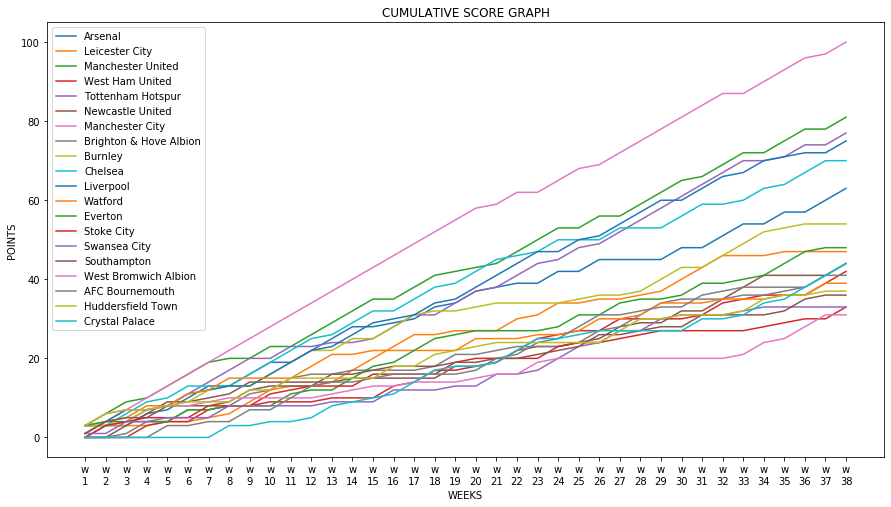

In [28]:
xlabel=pd.Series(x.index)
plt.figure(figsize=[15,8])
plt.subplot(1,1,1)
plt.plot(xlabel,x.values)
plt.xlabel("WEEKS")
plt.ylabel("POINTS")
plt.title("CUMULATIVE SCORE GRAPH")
plt.legend([i for i in x.columns])

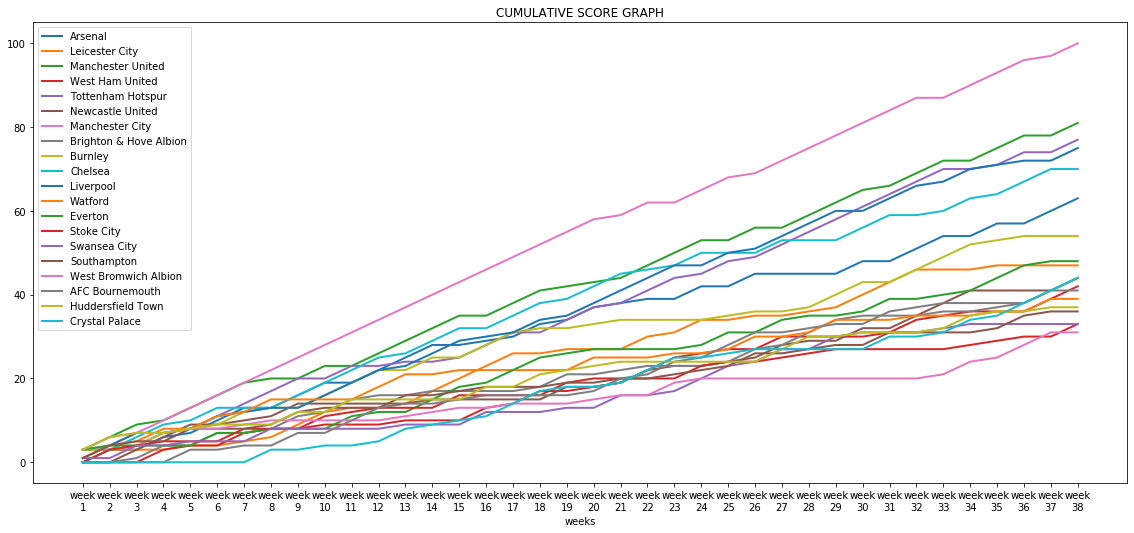

In [30]:
fig = plt.figure(figsize=(19,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
y = x.values
ax.plot([i for i in range(0,380,10)], y,linewidth=2)
ax.set_xlabel("weeks")
ax.set_title("CUMULATIVE SCORE GRAPH")
ax.set_xticks([i for i in range(0,380,10)])
ax.set_xticklabels(["week\n{}".format(i) for i in range(1,39)])
ax.legend([i for i in x.columns])
plt.show()

